![![University of Information Technology and Management in Rzeszow, Poland](https://gitlab.wsiz.pl/lgajecki/SA/-/raw/master/wsiz_eng.png)](wsiz_eng.png)

## Machine learning 
## Laboratory 5 (part 2) - Neural Networks in PyTorch

**Required for final test:** -  creation of neural networks (chapter 3) -class Net etc.. You will get function to get dataset and training code. Your task will be creation of network

**This laboratory** -  How to create neural networks. But the aim is to feel well in network creation look at chapter 3 (at least first example) - and how to create classes in Python.

**Project** - This laboratory may be the base for projects (ie. Team Project etc., find dataset on internet,develop something more). Important always remember to create network that differ from laboratory material, or tutorial (number of layers, number of neuron in hidden layer, nonlinear function or - difficult: another layer). It is also good to run and report your task on original network (citing sourse), then on your own network.

**Note** Pytorch library wraps large number of popular datasets ie: https://docs.pytorch.org/vision/main/datasets.html and https://docs.pytorch.org/vision/stable/models.html (torchvision), but also sub-library torchaudio, torchtext. 

In [1]:
import torch
import torch.nn.functional  as F
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

## 1. Fundamentals of object -oriented programming in Python

**Exercise 1.** To understand better the code of the network we will create simple class 

In [2]:
class A:

  def __init__(self,a, b):   # constructor, each method has to have 'self' -pointer for this object
    self.a=a   # first use of self.a - creates 'a' variable in this object ,  a - is regular variable (not self.a) 
    self.__b=b   # unsercores __ denote private variable

  def info(self):    # method without parameters, each method has to have 'self' at first place 
    print('Object contains variables a=',self.a,' b=',self.__b)   # access to self.a, self.b



objectA=A(1,2)    # creation of object, uses constructor for a=1, b=2
objectA.info()    # calling the metod
print ('objectA.a = ',objectA.a) # access to a variable from object
#print ('objectA.__b = ',objectA.__b) # no access to __b as private
 

Object contains variables a= 1  b= 2
objectA.a =  1


**Exercise 2.** Inheritance

In [3]:
class B(A):
  '''Here you can document class'''
  def __init__(self,a,b,c):
    super().__init__(a,b)  #calling constructor from base class. The super()
    self.c=c

  def info(self):
    '''Here you can document metod
    '''
    print(f"Object contains variables a={self.a} c={self.c}") ##b={self.__b}  no possible, since __b is provate

objectB=B(3,4,5)
objectB.info()

Object contains variables a=3 c=5


Classes can override several special metods like: 

> `__call__` - operator () -callable object

>`__iter__` -iterator , `__next__` -next position of iterator

>`__len__` - length of sequence

>`__getitem__` , `__setitem__`- indexer - operator []

>`__add__` operator +


See for details:  
https://docs.python.org/3/tutorial/classes.html# - _Python, Documentation-The Python Tutorial,chapter 9. Classes,_

https://docs.python.org/3/reference/datamodel.html?highlight=__call__#object.__call__ - _Python, Documentation-The Python Tutorial,chapter 3. Datamodel, paragraph: `object.__call__`_

We will check `__call__` which is used by Pythorch

**Exercise 3** Create class, which metod `__call__` calculate `x*k` where x is input, k object variable 

In [4]:
class MyLayer:
  def __init__(self,param):
    self.k=param

  def __call__(self,x):
    return self.k*x

layer=MyLayer(10)
result=layer(2)  #calls MyLayer.__call__(2)
print('Result of () ',result)

import numpy as np
x=np.array([1,2,3,5,10,15])
print('Result of layer(x) ',layer(x))

Result of ()  20
Result of layer(x)  [ 10  20  30  50 100 150]


Class `torch.nn.Module` require implemeentation of `forward()` method, which is called by `Module.__call__`.

Method `forward` is used as a calculation of a network layer, subnetwork or the whole network, where input is parameter of mmethod, and output is returned.

In [5]:
class MyLayer2(torch.nn.Module):
  def __init__(self,param):
    super().__init__()
    self.k=param

  def forward(self,x):  #__call__ calls this method
    return self.k*x

layer2=MyLayer2(10)
result=layer2(2)  #calls MyLayer.__call__(2)
print('Result of () ',result)

import numpy as np
x=np.array([1,2,3,5,10,15])
print('Result of layer(x) ',layer2(x))

Result of ()  20
Result of layer(x)  [ 10  20  30  50 100 150]


## <span id="section2">2.Dataset</span>
### 2.1 Dataset generation

In [6]:
feature_set, labels = datasets.make_moons(200, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(
    torch.from_numpy(feature_set).float(), torch.from_numpy(labels).float().unsqueeze(1), test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.5) # split train 0.5 *0.8=40%, valid: 0.8 * 0.5=40%, test  20%

#X_train=torch.from_numpy(X_train)
#X_valid=torch.from_numpy(X_valid)
#X_test=torch.from_numpy(X_test)

#y_train=torch.from_numpy(y_train)
#y_valid=torch.from_numpy(y_valid)
#y_test=torch.from_numpy(y_test)

print(f"{y_train.dtype} {y_valid.dtype} {y_test.dtype}")


torch.float32 torch.float32 torch.float32


Let we check the size of input and output vector. I will be necessairy to set the number of <span style='background:orange'>inputs of networks</span> the same as <span style='background:orange'>size of input vector</span>. Respectively <span style='background:lime'>number of  outputs </span> has to agree with <span style='background:lime'> output vector size </span>. Firstly we check the type of X_train - it is `torch.Tensor`. For this type (like for numpy) we have `.shape` property, and `size()` function

In [7]:
print(f'The type of X_train is {type(X_train)}')
print('X_train: ',X_train.shape,' y_train:',y_train.size())

The type of X_train is <class 'torch.Tensor'>
X_train:  torch.Size([80, 2])  y_train: torch.Size([80, 1])


This mean, that 80 is number of vectors, the input vector size is 2, the output vector size is 1.

### 2.2 Output encoding

The outputs of neurons will take respective forms depends on the task of network:
- **Regression** - the network try to follow y values. Network can represent the function transforming x into y (The application can be learn of unknown function or prediction of future data). Then outputs will be a vector of floating point numbers. The size of outputs will be the same as single vector y.
- **Classification** - the network divides input data into several classes. For example what letter is on image: 'A','B, or 'C' (here 3 classes). The output encoding is one-hot. In this encoding one output- which refer to recognized class is `1` , the rest outputs i `0`. In dicussed example, letter 'C' will be encoded as `[0,0,1]` The outputs folow to this values, the resulting output will be `0` or `1` depends which value is closer to (so in our example real output can be `[0.23,0.1,0.9]`).
- **Two class classification** - this is also classification as above. However having two classes we can have two outputs (as above). We can use one neuron, which output closer to `0` will mean one class, and closer to `1` will mean second class  

In all above cases the construction of the network will be the same, but only respective coding of y will be needed.

In this material we generated a [dataset](#section2) using `make_moons` function, which gives labels of two class, as single value `0` or `1` 


## 3.Neural Networks in PyTorch

    class Net(torch.nn.Module):

        def __init__(self):   # def __init__(self,n_inp,n_out) ->  model=Net3(2,1)
            super(Net, self).__init__()
            self.linear1 = torch.nn.Linear(3, 2)
            self.linear2 = torch.nn.Linear(2, 1)

        def forward(self, x):

            h_relu = F.relu(self.linear1(x))
            y_out = F.relu(self.linear2(h_relu))
            return y_out


At constructor `def __init__(self)` we declare the layers: `self.linear1=torch.nn.Linear(3,2)` , so here the `linear1` will be the member of the class. The  constructor class `Layer` has parameters: `Layer(n_inputs,n_outputs)`-respectively number of inputs and number of outputs. Next there is the declaration of second layer `linear2`. Note, that number of outputs (=2) of first layer `layer1` **has to agree with number of inputs to the second layer** `layer2`. Number of inputs of `layer1` (=3) **has to agree with number of network inputs**, and the same way: numer of outputs of `linear2` layer has to **agree with the number of network outputs**

Function def forward(self, x): contains all the computation to calculate network output. For example `h_relu = F.relu(self.linear1(x))` caculates the output of 'linear1 for given' `x`, then calculates nonlinear function (at pytorch documentation there are some layers and nonlnear functions).

Example of new network calculations:

`model=Net()` - new object none parameters

`y_pred = model(x)` - calculating the output of neaural network (calling `forward(...)`)

<div class="alert alert-block alert-info">
    <b>Hint</b> to solve the problems with size of layers we can debug forward method or add print() there to check the size of vectors, ie. :</div>

        def forward(self, x):

            h_relu = F.relu(self.linear1(x))
            print('h_relu:',h_relu.shape)
            y_out = F.relu(self.linear2(h_relu))
            return y_out


<div class="alert alert-block alert-danger">
    <b>Hint</b> In shared disc (Shared disc at WU == K: == ftp:\\ftp.wsiz.rzeszow.pl\..\WSPOLNY\ ) in course folder  K:\LGajecki\ComputIntelligence  you can find file  Lab2\Lab2_sieci_pytorch.pdf , where I point to connections between layers, number of inputs and outs of the network </div>

In [8]:
class Net(torch.nn.Module):
  """
  In the constructor we instantiate two nn.Linear modules and assign them as
  member variables.
  """
  def __init__(self):   # def __init__(self,n_inp,n_out) ->  model=Net3(2,1)
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=2, out_features=5) 
        # parameters of Linear may be also positional parameters: self.linear1 = torch.nn.Linear(2,5)
        self.linear2 = torch.nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = F.relu(self.linear1(x)) #F.leaky_relu
        #print('h_relu:',h_relu.shape)
        y_out = F.relu(self.linear2(h_relu))
        return y_out 



Input is size 2, output size 1. The network has 2 layers: layer 1- 5 neurons , Relu activation, layer 2- 1 neuron 

Check other activation functions: 
https://pytorch.org/docs/stable/nn.functional.html 
https://pytorch.org/docs/stable/nn.html _Pytorch Documentation (torch.nn.functional, torch.nn )_

Training code. You can add the plotting of y_pred value.

In [9]:
def training(model,X_train,y_train,X_valid,y_valid,X_test,y_test):

    train_err=[]
    valid_err=[]

    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #Adam

    for t in range(20000):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X_train)
        
        # Compute and print loss
        loss = criterion(y_pred, y_train)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        tr_err=loss.item()
        train_err.append(tr_err)
        
        #validation, no gradient calculation
        with torch.no_grad():
            y_pred = model(X_valid)
            loss = criterion(y_pred, y_valid)
            valid_err.append(loss.item())
    
        if t % 1000 == 0 or ( t<1000 and t % 100 ==0 ):
            print(f"iter: {t} traning err: {tr_err} validation err: {loss.item()}")
    
    #test, no gradient calculation
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        print("Test error:",loss.item())
                  
    return train_err,valid_err

<div class="alert alert-block alert-success">
    <b>Hint</b> Note the elements of training code in <emb>training() </emb> function which has influence on traing</div>

- The most fundamental is *learning rate* parameter, which is denoted as `lr` in line:
```
torch.optim.SGD(model.parameters(), lr=1e-3)
```

> Note that `torch.optim.SGD`contains also other optional parameters ie.`momentum`, `weight_decay`

- Other optimizers (than `SGD`) may improve training: Adam,Adadelta, etc, you can find them in documentation for namespace `torch.optim` 

> Optimizers: https://pytorch.org/docs/stable/nn.optim.html _Pytorch Documentation (torch.nn.optim )_

- Other loss functions (than MSELoss) are in namespace torch.nn . Important to note, that some of them expect y_train (target) as vector of output values (like for regression, but works for classification) ie. `MSELoss`, `L1Loss`. Others require y_train vector as id of class (like: `[2,5,1]`), but also as the vector of class probabilities (like `[0.1,0.1,0.8],[0.2,0.5,0.3],[0.1,0.9,0]`, you may use softmax to normalize the to 1) ie. `CrossEntropyLoss` ,`CTCLoss`,`NLLLoss`

> Loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions _Pytorch Documentation (torch.nn , section: Loss Functions )_

<div class="alert alert-block alert-info">
    <b>Hint</b> During training you may stuck in local minimum. You need then create object of network again (pytorch initialize randomly parameters , but in __init__, it means in creations of layers etc. )</div>
          

In [10]:
model=Net()

train_err,valid_err = training(model,X_train,y_train,X_valid,y_valid,X_test,y_test)

iter: 0 traning err: 41.0 validation err: 41.0
iter: 100 traning err: 41.0 validation err: 41.0
iter: 200 traning err: 41.0 validation err: 41.0
iter: 300 traning err: 41.0 validation err: 41.0
iter: 400 traning err: 41.0 validation err: 41.0
iter: 500 traning err: 41.0 validation err: 41.0
iter: 600 traning err: 41.0 validation err: 41.0
iter: 700 traning err: 41.0 validation err: 41.0
iter: 800 traning err: 41.0 validation err: 41.0
iter: 900 traning err: 41.0 validation err: 41.0
iter: 1000 traning err: 41.0 validation err: 41.0
iter: 2000 traning err: 41.0 validation err: 41.0
iter: 3000 traning err: 41.0 validation err: 41.0
iter: 4000 traning err: 41.0 validation err: 41.0
iter: 5000 traning err: 41.0 validation err: 41.0
iter: 6000 traning err: 41.0 validation err: 41.0
iter: 7000 traning err: 41.0 validation err: 41.0
iter: 8000 traning err: 41.0 validation err: 41.0
iter: 9000 traning err: 41.0 validation err: 41.0
iter: 10000 traning err: 41.0 validation err: 41.0
iter: 11000

In [11]:
model

Net(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

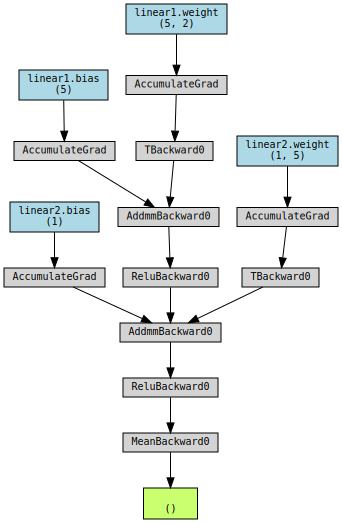

In [12]:
from torchviz import make_dot
#y = model(X)# Required
y_pred = model(X_train)
make_dot(y_pred.mean(), params=dict(model.named_parameters()))

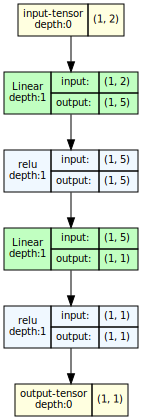

In [13]:
from torchview import draw_graph

batch_size = 1
# device='meta' -> no memory is consumed for visualization, (LG): but later problems with training etc.
model_graph = draw_graph(model, input_size=(batch_size, 2), device='cpu')
model_graph.visual_graph

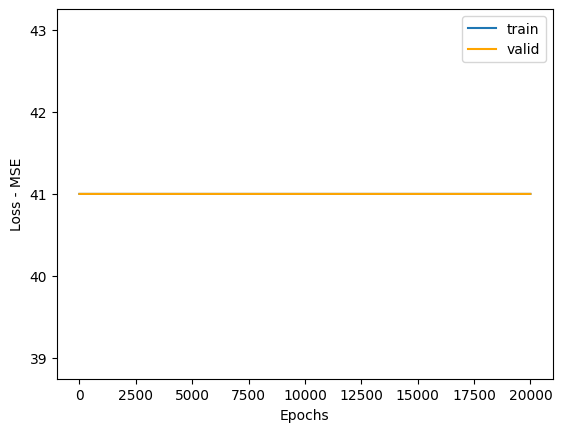

In [14]:
def plot_training(train_err,valid_err):
    #show how the error drops vs training time
    #show how accuracy incrases vs training time
    #x axis shows the epoch number
    #y axis shows the error for given epoch
    #second y acix show the accuracy for given epoch

    fig = plt.figure()

    ax1 = fig.add_subplot(111)
    ax1.set_xlabel(r"Epochs")  #adds description to scale on bottom
    ax1.set_ylabel(r"Loss - MSE")  #adds description to scale on bottom

    ax1.plot(train_err)       #draw function 
    ax1.plot(valid_err, c="orange")
    ax1.legend(['train','valid'])

    plt.show()
    
plot_training(train_err,valid_err)

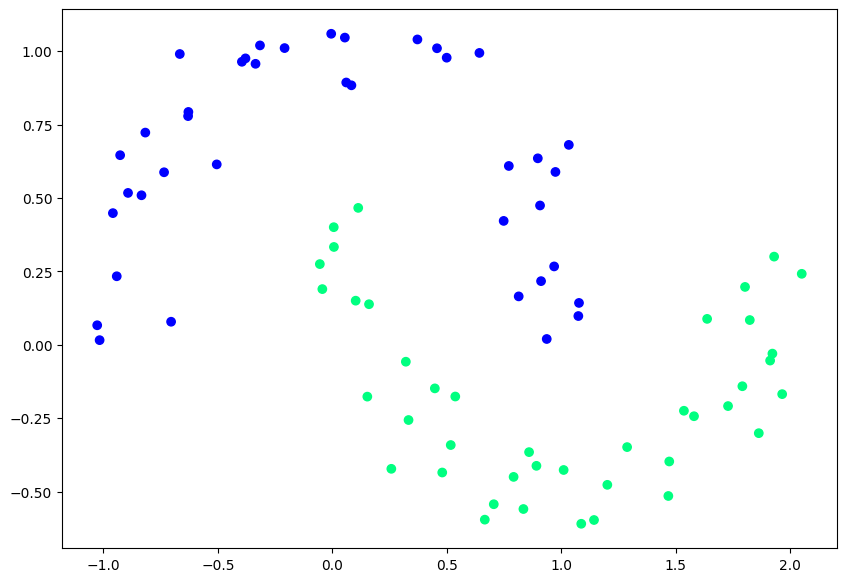

In [15]:
# visualisation of the dataset for analysis
plt.figure(figsize=(10,7))
X_train.numpy().shape, y_train.numpy().shape
plt.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], c=y_train.numpy(), cmap=plt.cm.winter)

### Decission boundary

In [16]:
def draw_decission_boundary(model,xmin,xmax,ymin,ymax,steps=100):

    cmap = plt.get_cmap('Paired')

    #steps = 100

    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)


    # Plot decision boundary in region of interest

    z = np.zeros(xx.shape,dtype=int)

    ii=0
    for i in x_span:
        jj=0
        for j in y_span:
    
            classification_criteria = 0.5

            if model(torch.tensor([i,j]).float()) > classification_criteria:
            #if i==j :
                z[jj,ii] = 1
            jj=jj+1
        ii=ii+1

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    #train_labels = model.predict(X)
    #ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    plt.scatter(feature_set[:,0], feature_set[:,1], c=labels, cmap=plt.cm.winter)

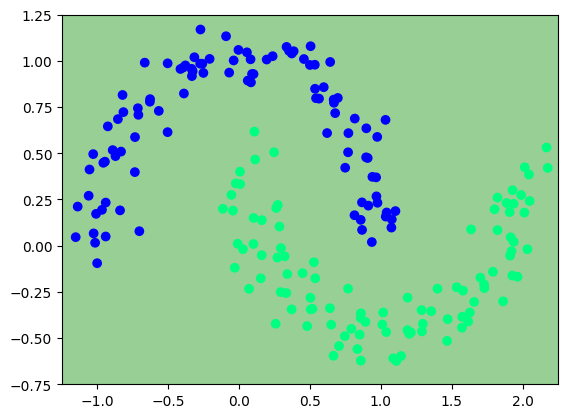

In [17]:
# Define region of interest by data limits
#xmin = -1.25 
#xmax = 2.25
#ymin = -0.75
#ymax = 1.25

#model - pytorch network

draw_decission_boundary(model,-1.25,2.25,-0.75,1.25)

## 4. To compare: torch.nn.Sequential 

To remind, let's we build the same network as in point 3, using torch.nn.Sequential (last class)

In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(2,5), 
    torch.nn.ReLU(),
    torch.nn.Linear(5,1),
    torch.nn.ReLU()
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): ReLU()
)


iter: 0 traning err: 41.0 validation err: 41.0
iter: 100 traning err: 41.0 validation err: 41.0
iter: 200 traning err: 41.0 validation err: 41.0
iter: 300 traning err: 41.0 validation err: 41.0
iter: 400 traning err: 41.0 validation err: 41.0
iter: 500 traning err: 41.0 validation err: 41.0
iter: 600 traning err: 41.0 validation err: 41.0
iter: 700 traning err: 41.0 validation err: 41.0
iter: 800 traning err: 41.0 validation err: 41.0
iter: 900 traning err: 41.0 validation err: 41.0
iter: 1000 traning err: 41.0 validation err: 41.0
iter: 2000 traning err: 41.0 validation err: 41.0
iter: 3000 traning err: 41.0 validation err: 41.0
iter: 4000 traning err: 41.0 validation err: 41.0
iter: 5000 traning err: 41.0 validation err: 41.0
iter: 6000 traning err: 41.0 validation err: 41.0
iter: 7000 traning err: 41.0 validation err: 41.0
iter: 8000 traning err: 41.0 validation err: 41.0
iter: 9000 traning err: 41.0 validation err: 41.0
iter: 10000 traning err: 41.0 validation err: 41.0
iter: 11000

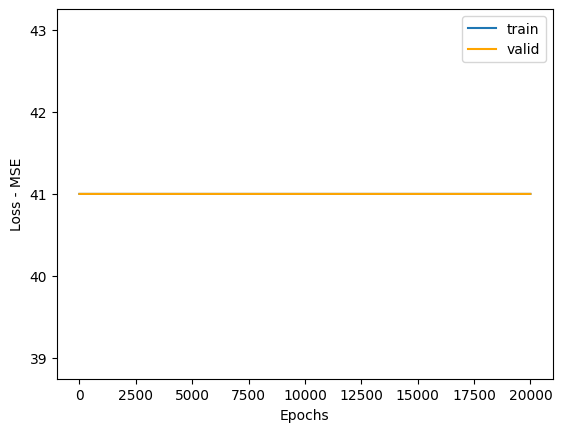

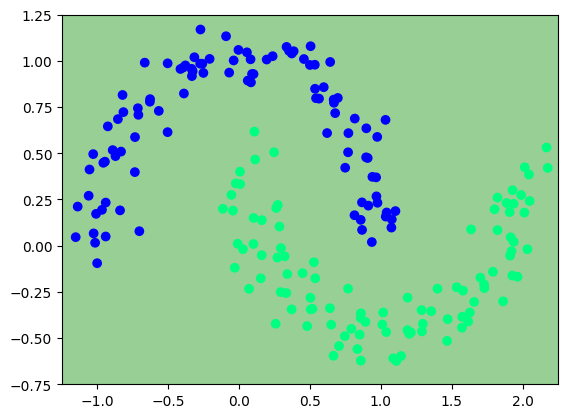

In [19]:
train_err,valid_err = training(model,X_train,y_train,X_valid,y_valid,X_test,y_test)
plot_training(train_err,valid_err)
draw_decission_boundary(model,-1.25,2.25,-0.75,1.25)

<div class="alert alert-block alert-info">
    <b>Conclussion</b> Look at training figure. Observe training curve -training loss should decrease (or in case of fluctuation general trend should be decrease). Validation loss should decrease, but at some point may increase. Valiedation error means how good the network recognise new unseen data points. If validation error increase means that network is overtrained. Training should be stopped. More commlex network : ie. more neurons in hidden layers (layers befor last layer), or more layers can convey complexity of problem. But too complex network can be overtrained more.</div>

You may also name the layers if you need (this doesn't change network operation, only may help in printing, inspecting complicated structure)

In [20]:
from collections import OrderedDict

model = torch.nn.Sequential(OrderedDict([
    ('linear layer 1',torch.nn.Linear(2,5)), 
    ('relu1',torch.nn.ReLU()),
    ('linear2',torch.nn.Linear(5,1)),
    ('relu2',torch.nn.ReLU())
]))
print(model)

Sequential(
  (linear layer 1): Linear(in_features=2, out_features=5, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (relu2): ReLU()
)


## 5.Comparison of networks with different number of layers ###

3 layers

In [21]:
class Net2(torch.nn.Module):

  def __init__(self): 
        super(Net2, self).__init__()
        self.linear1 = torch.nn.Linear(2, 5)
        self.linear2 = torch.nn.Linear(5, 5)
        self.linear3 = torch.nn.Linear(5, 1)

  def forward(self, x):

        x = F.relu(self.linear1(x)) 
        x = F.relu(self.linear2(x))
        y_out = F.relu(self.linear3(x))
        return y_out 

In [22]:
# model=Net2()
# paste here code for training and figures

1 neuron

In [23]:
class Net3(torch.nn.Module):

  def __init__(self):   # def __init__(self,n_inp,n_out) ->  model=Net3(2,1)
        super().__init__()
        self.linear1 = torch.nn.Linear(2, 1)

  def forward(self, x):

        y_out = F.relu(self.linear1(x))
        return y_out 

In [24]:
# paste here code for training and figures

## 6. Debugging

In section 3 we told, that you may add for example print(x.shape) in forward() method. To see actual shape of vector, or point ,where network still works.

Debugging of `Sequential` structure is a bit more difficult. If there is disagreement between ie. output of layer 1, and input of layer 2, you will see an error during training. Example error coud be
```
mat1 and mat2 shapes cannot be multiplied (80x5 and 4x1)
```
You may guess, which layer gives you 5 outputs, and wich layer has 4 inputs. Like in below code

In [25]:
model = torch.nn.Sequential(
    torch.nn.Linear(2,5),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.ReLU()
)

In [26]:
train_err,valid_err = training(model,X_train,y_train,X_valid,y_valid,X_test,y_test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x5 and 4x1)

Let we make debugging "module":

In [ ]:
class Debugging(torch.nn.Module):
    def forward(self,x):
        print('x=',x.shape)
        return x
    
# or more beatyfully as an std.err stream
# import sys
# class Debugging(torch.nn.Module):
#     def forward(self,x):
#         print('x=',x.shape, file=sys.stderr)
#         return x

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2,5),
    Debugging(),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.ReLU()
)

In [ ]:
train_err,valid_err = training(model,X_train,y_train,X_valid,y_valid,X_test,y_test)
plot_training(train_err,valid_err)
draw_decission_boundary(model,-1.25,2.25,-0.75,1.25)

#### **Mandatory exercises** (70% points): 

**1.** Run the code

**2.** Add the code for training and figures in chapter 5, as it was for `Sequential` example (chapter 4). Run this code

**Exercises for bigger grade (100% points)** (3 exercises required for this report and `Lab5.ipynb` together).

**3.** Compare different networks with different numbers of layers, what did you note? What are your conclussions from  training curves, and what are conclussions from decission boundaries?

**4.** Change the structure on any neural network (number of neuron in hidden layer, nonlinear function or - difficult: another layer) Change of number of layers is possible for this exercise, but for other cases than laboratory examples (ie. possible, change activation function, then number of layers, or other number of layers than in laboratory). Try to find better results, than given networks

**5.** Make changes in training function and make separate run of traing one choosen network each time(learning rate at least 2 tries, but at least one training with use another parameters of `SGD` optimizer or use another optimizer or loss function. To prove this work you may list of changes - and describe resuts- differences to base case ie:

No | Change | Result
---|--------|----------
1|  lr=...| training was ....
2 | lr=... momentum=...  | ....description

Or create separate block for changed `training()` function, then block for traing code and drawing figures. Next new block for new version of `training()` . Please write, what you changed. 

**6.** Extend the visualisation of dataset. In chapter 3 the training set is visualized only. Draw also validation and test set. If possible use other marks for that points to distuinguish such sets. 

**7.** Create network with residual layers. Such layers take the input not only from previous layer (as y=F(x) ) , but also add with weights the input: y=F(x)+x , you may construct network, which got inputs from previous layer y=F2( \[ F1(x) x\]) 

**Write here, which exercises you did:**

In [ ]:
#I did exercises 1,2,4 in file lab5.ipynb